# AI/DSci Project
### Group Members:
##### Abdul Waris Khan K190175
##### Muhammad Haroon K190145
##### Ibrahim K191311

#### Imports

In [ ]:
 !pip install nltk pandas numpy sklearn bs4 transformers simpletransformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 249 kB 75.0 MB/s 
     |████████████████████████████████| 6.6 MB 50.2 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 1.8 MB 44.0 MB/s 
     |████████████████████████████████| 1.2 MB 61.4 MB/s 
     |████████████████████████████████| 346 kB 76.2 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 10.1 MB 32.7 MB/s 
     |████████████████████████████████| 181 kB 68.7 MB/s 
     |████████████████████████████████| 145 kB 64.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 55.1 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████|

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from transformers import BertPreTrainedModel, BertConfig, BertModel, BertTokenizer, AdamW
from transformers import XLNetTokenizer, XLNetModel, XLNetPreTrainedModel, XLNetConfig
from simpletransformers.classification import ClassificationModel
import logging
logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, RandomSampler, Dataset, SequentialSampler
from sklearn.utils import shuffle

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/FAST!!/6th Semester/Personal/AI/IMDB Dataset.csv', sep= ',', encoding = 'Latin-1')
dataset.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

### Dataset Shape

In [ ]:
# Dataset Contains 50k samples
dataset.shape

(50000, 2)

In [ ]:
dataset.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
# Strip Dataset
# dataset = dataset[:500]

In [ ]:
# Checking for Abnormal Data
for i in range(2):
    print(i,dataset.iloc[i][0],end='\n\n')

0 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

#### Encode Target (Sentiment) Column

In [ ]:
dataset['sentiment'] = dataset['sentiment'].map({'positive': 1, 'negative': 0})
dataset.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

#### Cleaning Reviews

In [ ]:
# Removing Stop Words
stop_words = set(stopwords.words("english"))
print("STOP WORDS: ")
print(stop_words)
print()
print()

# Lemmatizer Initialization
lemmatizer = WordNetLemmatizer()

# Getting rid of HTML using BeautifulSoup4
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def cleaner(row):
    row = remove_html(row)
    # Replacing/removing required stuff
    #row = re.sub('<br />|\,|\:|\'|\"|\(|\|\\|\/|\!|\)|\?|\*|\%|\@|\#|\$|\^|\_|\=|\;', '', row)
    #row = re.sub('\.|-|\<|\>|\`|\~', ' ', row)
    row = re.sub('\+', ' plus ', row)
    row.replace('&', 'and')
    
    # Lower the Text
    row = row.lower()
    
    # remove anything other than letters and numbers
    row = re.sub(r'[^A-Za-z0-9]+', ' ', row)
    
    # Lemmatizing and Removing Stop Words
    row = [lemmatizer.lemmatize(token) for token in nltk.word_tokenize(row)]
    row = [lemmatizer.lemmatize(token, "v") for token in row]
    row = [word for word in row if not word in stop_words]
    row = " ".join(row)
    return row


dataset['review'] = dataset['review'].apply(cleaner)

for i in range(len(dataset)):
    print(i, dataset.iloc[i][0], end='\n\n')
    

Streaming output truncated to the last 5000 lines.
838 harrison ford play sergeant dutch van den broeck district columbia police department try get bad guy good job meet try catch corrupt undercover officer kristin scott thomas play new hampshire senator kay chandler try get reelect run candidate ha plenty money last thing need death husband politician bogged feel story move slowly painfully wa look watch every five minute wonder would story get lose detail director sydney pollack need put want know dutch police investigation throw insight politician spin control campaign see movie still wonder get involve romantically anybody mourn anymore need two week even consider go horizontal someone else wa good see actress comedian chicago native second city alumnus bonnie hunt role necessarily comic relief wa one want see favor wait video want see

839 mishima life four chapter opinion best paul schrader film day mesmorizing cinematography accompany philip glass mystical musical score add comp

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
26700 rather surprise anybody find film touch move basic premise film sound like excellent provocative idea movie rare sort relationship one judge real life example know extremely deep love however film cheaply script poorly script although ha number pretty look shoot find anything special probably biggest problem far short poorly compose give audience time enough invest emotionally character really care stress obstacle really touch u think remake screenplay character development really good writer could improve greatly instructive compare film brokeback mountain screen writer take far loftier level author screenplay screen writer clearly conscious write classical tragedy carry task care plan superb craftsmanship however people seem remake film need really miss anything skip one find disappoint indeed save get 1 star virtue dare gumption take make film sensitive subject

26701 big fan movie make think still think long hard one fully se

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# The model has now a lot fewer symbols and different words to process
# This generalization will help in maintaining high accuracy.
dataset

review  sentiment
0      One of the other reviewers has mentioned that ...          1
1      A wonderful little production. <br /><br />The...          1
2      I thought this was a wonderful way to spend ti...          1
3      Basically there's a family where a little boy ...          0
4      Petter Mattei's "Love in the Time of Money" is...          1
...                                                  ...        ...
49995  I thought this movie did a down right good job...          1
49996  Bad plot, bad dialogue, bad acting, idiotic di...          0
49997  I am a Catholic taught in parochial elementary...          0
49998  I'm going to have to disagree with the previou...          0
49999  No one expects the Star Trek movies to be high...          0

[50000 rows x 2 columns]

([<matplotlib.axis.XTick at 0x7f0370f33cd0>,
 [Text(0, 0, 'Positive'), Text(0, 0, 'Negative')])

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) =

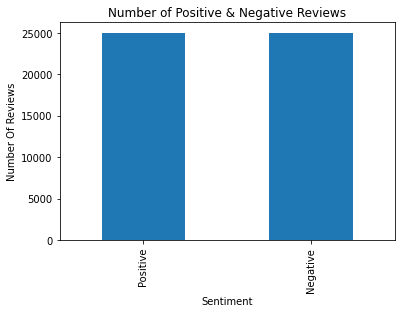

In [ ]:
# This is the bar plot of number of reviews in dataset categorized on positive and negative
dataset.sentiment.value_counts().plot.bar(title="Number of Positive & Negative Reviews", xlabel="Sentiment", ylabel="Number Of Reviews")
plt.xticks([0,1], ["Positive", "Negative"], rotation='vertical')

In [ ]:
# Shuffling the Dataset
dataset = shuffle(dataset)
dataset.reset_index(inplace=True, drop=True)
dataset.head()

review  sentiment
0  **SPOILERS**Actually based on the novel "The B...          1
1  Anton Newcombe makes the film and he is the ma...          1
2  I got this as a turkey movie and was I not dis...          0
3  I watched this film a few times in the 90's an...          1
4  Night Hunter starts in '1968' as a young Jack ...          1

In [ ]:
# Pos/Net Words Graph
ps=dataset[dataset['sentiment']==1]
ns=dataset[dataset['sentiment']==0]


In [ ]:
pdf= ps['review'].str.split(' ')
ndf = ns['review'].str.split(' ')
# ndf
pdf=pd.DataFrame(pdf)
ndf=pd.DataFrame(ndf)

pdf.set_axis(['review'],axis=1)
ndf.set_axis(['review'],axis=1)


pdf['length']=pdf['review'].apply(len)
ndf['length']=ndf['review'].apply(len)

In [ ]:
print(ndf)
print(pdf)

# review lengths average
print(np.average(ndf['length']))
print(np.average(pdf['length']))

                                                review  length
0    [standard, view, purely, awful, movie, however...      47
2    [im, big, fan, boll, work, many, enjoy, movie,...     230
3    [believe, ha, ever, evil, wicked, television, ...     256
4    [sit, pile, dung, husband, wonder, whether, wa...     141
5    [hill, eye, ii, would, expect, nothing, course...     106
..                                                 ...     ...
193  [unmarried, woman, name, stella, bette, midler...     110
194  [scotty, grant, cramer, would, go, star, great...     103
195  [revolt, zombie, prof, director, revamp, recyc...     233
196  [watch, film, really, expect, much, get, pack,...     117
198  [encourage, positive, comment, film, wa, look,...      66

[115 rows x 2 columns]
                                                review  length
1    [watch, movie, premier, night, curiosity, shee...     155
7    [best, version, far, see, true, bronte, work, ...      57
9    [family, travel, mid, west

In [ ]:
plt.plot(ndf['length'],label='Negative')
plt.plot(pdf['length'],label='Positive')
plt.legend()
plt.show()

In [ ]:
psv=ps['review'].str.split(' ')
nsv=ns['review'].str.split(' ')
psv = pd.DataFrame(psv.tolist()).stack().reset_index(level=1, drop=True).reset_index(name='words')[['words']]
nsv = pd.DataFrame(nsv.tolist()).stack().reset_index(level=1, drop=True).reset_index(name='words')[['words']]


In [ ]:
# ptstr=psv.loc[0].apply(join)
# pdf=pd.DataFrame(pdf)
# ndf=pd.DataFrame(ndf)

# pdf.set_axis(['review'],axis=1)
# ndf.set_axis(['review'],axis=1)

psv=pd.DataFrame(psv)
nsv=pd.DataFrame(nsv)

psv.set_axis(['words'],axis=1)
nsv.set_axis(['words'],axis=1)


words
0         holy
1           sh
2           wa
3          god
4        awful
...        ...
31816   really
31817   wonder
31818     feel
31819   career
31820  actress

[31821 rows x 1 columns]

In [ ]:
len(psv['words'])
pos = set(psv['words'])
neg = set(nsv['words'])

In [ ]:
pstr=' '.join(pos) #make all positive words into string
nstr=' '.join(neg) #make all negative words into string


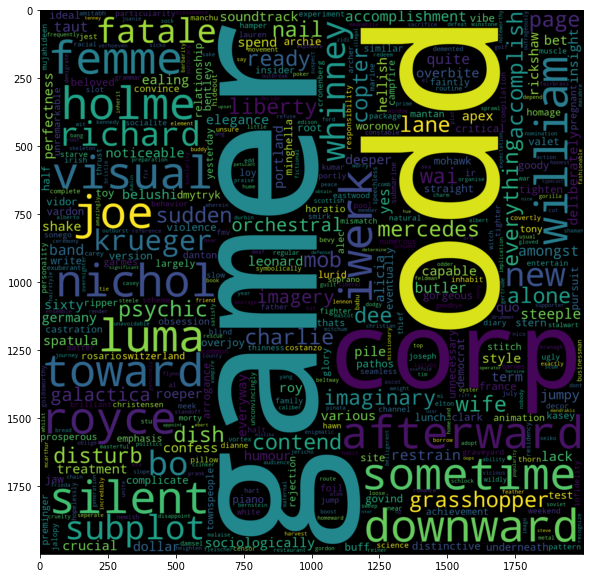

In [ ]:
plt.figure(figsize=(10,10))
# positive_text=pdf['review'][0]
WC=WordCloud(width=2000,height=2000,max_words=500,min_font_size=5)
positive_words=WC.generate(pstr)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

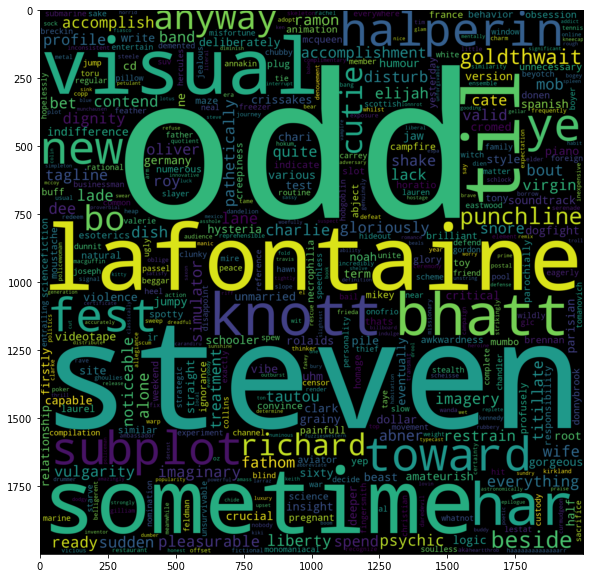

In [ ]:
plt.figure(figsize=(10,10))
# positive_text=pdf['review'][0]
WC=WordCloud(width=2000,height=2000,max_words=500,min_font_size=5)
negative_words=WC.generate(nstr)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()


In [ ]:
# Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.review, dataset.sentiment, test_size=0.3, random_state=21)

n = int(len(dataset)*0.7)
train_df = dataset[:n]
test_df = dataset[n:]

# Algorithms
#### XL Net


In [ ]:
import torch

cuda_available = torch.cuda.is_available()
cuda_available

True

In [ ]:
X_train

123     better yet watch fandango want see really inte...
893     one watch straight face script bad even ferrel...
1226    saw film get screw film wa foolish bore think ...
1316    warn spoiler agree wa almost wa bad movie inte...
518     edmund lowe remind somewhat warren william hea...
                              ...                        
368     really cant think anything good say film singl...
48      remember see film mid 80 think well pace well ...
772     beat horror movie seem get nothing bad review ...
1231    oh one attack japanese ghost girl movie even r...
969     walt disney 20th animate feature wa last one g...
Name: review, Length: 1050, dtype: object

In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 1,
    'learning_rate': 0.00001,
    'weight_decay': 0.01,
    'train_batch_size': 128,
    'fp16': True,
    'output_dir': '/outputs/',
}

In [ ]:
# We use the XLNet base cased pre-trained model.
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=2, args=train_args, use_cuda=cuda_available) 

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /xlnet-base-cased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /xlnet-base-cased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceC

In [ ]:
# Train the model
model.train_model(train_df)



/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/350 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: 1263 features created from 350 samples.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to /outputs/.


(10, 0.7219016373157501)

In [ ]:
# Evaluate the model in terms of accuracy score
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score, cc=sklearn.metrics.classification_report)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/150 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: 150 features created from 150 samples.


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.06895966054592131, 'tp': 7, 'tn': 75, 'fp': 5, 'fn': 63, 'acc': 0.5466666666666666, 'cc': '              precision    recall  f1-score   support\n\n         0.0       0.54      0.94      0.69        80\n         1.0       0.58      0.10      0.17        70\n\n    accuracy                           0.55       150\n   macro avg       0.56      0.52      0.43       150\nweighted avg       0.56      0.55      0.45       150\n', 'eval_loss': 0.701934814453125}


In [ ]:
print(result['cc'])

# result

# p = result['tp']/result['tp']+result['fp']
# r = result['tp']/result['tp']+result['fn']
# f = 2*((p*r)/p+r)
# a = (result['tp']+result['tn'])/(result['tp']+result['tn']+result['fp']+result['fn'])

# print("Precision: ", p)

# print("Recall: ", r)

# print("F1-score: ", f)

# print("Accuracy: ", a)

              precision    recall  f1-score   support

         0.0       0.54      0.94      0.69        80
         1.0       0.58      0.10      0.17        70

    accuracy                           0.55       150
   macro avg       0.56      0.52      0.43       150
weighted avg       0.56      0.55      0.45       150



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8940847890>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8940847890>
DEBUG:matplotlib.colorbar:Setting pcolormesh


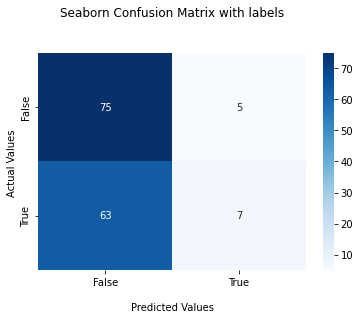

In [ ]:
# Confusion Matrix Of Results
import seaborn as sns
labels = [result['tn'], result['fp'],result['fn'],result['tp']]

labels = np.asarray(labels).reshape(2,2)
cf_matrix = [[result['tn'], result['fp']], [result['fn'], result['tp']]]
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print("ACCURACY: ")
result['acc']*100

ACCURACY: 


54.666666666666664

In [ ]:
# BERT

In [ ]:
# We use the XLNet base cased pre-trained model.
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args=train_args, use_cuda=cuda_available)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a 

In [ ]:
# Train the model
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/350 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
INFO:simpletransformers.classification.classification_model: 1253 features created from 350 samples.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to /outputs/.


(10, 0.6944527924060822)

In [ ]:
# Evaluate the model in terms of accuracy score
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score, cc=sklearn.metrics.classification_report)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/150 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
INFO:simpletransformers.classification.classification_model: 150 features created from 150 samples.


Running Evaluation:   0%|          | 0/68 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.049629166698546515, 'tp': 3, 'tn': 78, 'fp': 2, 'fn': 67, 'acc': 0.54, 'cc': '              precision    recall  f1-score   support\n\n         0.0       0.54      0.97      0.69        80\n         1.0       0.60      0.04      0.08        70\n\n    accuracy                           0.54       150\n   macro avg       0.57      0.51      0.39       150\nweighted avg       0.57      0.54      0.41       150\n', 'eval_loss': 0.6908482567352408}


In [ ]:
print(result['cc'])

# result

# p = result['tp']/result['tp']+result['fp']
# r = result['tp']/result['tp']+result['fn']
# f = 2*((p*r)/p+r)
# a = (result['tp']+result['tn'])/(result['tp']+result['tn']+result['fp']+result['fn'])

# print("Precision: ", p)

# print("Recall: ", r)

# print("F1-score: ", f)

# print("Accuracy: ", a)

              precision    recall  f1-score   support

         0.0       0.54      0.97      0.69        80
         1.0       0.60      0.04      0.08        70

    accuracy                           0.54       150
   macro avg       0.57      0.51      0.39       150
weighted avg       0.57      0.54      0.41       150



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f89381ef1d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f89381ef1d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


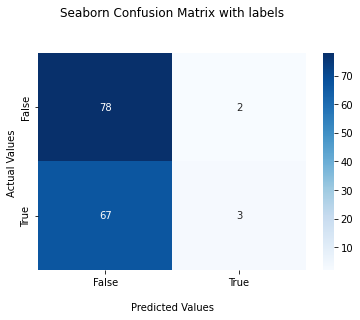

In [ ]:
# Confusion Matrix Of Results
import seaborn as sns
labels = [result['tn'], result['fp'],result['fn'],result['tp']]

labels = np.asarray(labels).reshape(2,2)
cf_matrix = [[result['tn'], result['fp']], [result['fn'], result['tp']]]
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print("ACCURACY: ")
result['acc']*100

ACCURACY: 


54.0

In [ ]:
### Ensemble

In [ ]:
out = None
logits = None
class BertXLNetEnsemble(BertPreTrainedModel, XLNetPreTrainedModel):
  def __init__(self, config, config2, *args, **kwargs):
      BertPreTrainedModel.__init__(self, config)
      XLNetPreTrainedModel.__init__(self, config2)
      
      # BERT Model
      self.bert_model = BertModel(config)
      # XLNET Model
      self.XLNet_model = XLNetModel(config2)

      # combine the 2 models into 1
      self.cls = nn.Linear(2 * 1024, 2)
      self.init_weights()

  def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          next_sentence_label=None,
          labels=None,
  ):
    global out, logits
    outputs = []
    input_ids_1 = input_ids[0]
    attention_mask_1 = attention_mask[0]
    outputs.append(self.bert_model(input_ids_1,
                                     attention_mask=attention_mask_1))

    input_ids_2 = input_ids[1]
    attention_mask_2 = attention_mask[1]
    outputs.append(self.XLNet_model(input_ids_2,
                                     attention_mask=attention_mask_2))
    
    out = outputs
    last_hidden_states = torch.cat([output[0] for output in outputs], dim=2)
    logits = self.cls(last_hidden_states)

    if next_sentence_label is not None:
      loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
      next_sentence_loss = loss_fct(logits.view(-1, 2), next_sentence_label.view(-1))
      return next_sentence_loss, logits
    else:
      loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
      loss = loss_fct(logits.view(-1, 512), labels.view(-1))
      return loss, logits

In [ ]:
device = torch.device("cuda")
print(device)
config = BertConfig(hidden_size=1024, num_attention_heads=16)
config2 = XLNetConfig()
model = BertXLNetEnsemble(config, config2)
model.to(device)
berttokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
xlnettokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
learning_rate = 1e-5

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [{
  "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
  }]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

cuda


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-bas

In [ ]:
print(config.get_config_dict('bert-base-uncased'))
print(config.get_config_dict('xlnet-base-cased'))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443


({'architectures': ['BertForMaskedLM'], 'attention_probs_dropout_prob': 0.1, 'gradient_checkpointing': False, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'layer_norm_eps': 1e-12, 'max_position_embeddings': 512, 'model_type': 'bert', 'num_attention_heads': 12, 'num_hidden_layers': 12, 'pad_token_id': 0, 'position_embedding_type': 'absolute', 'transformers_version': '4.6.0.dev0', 'type_vocab_size': 2, 'use_cache': True, 'vocab_size': 30522}, {})


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /xlnet-base-cased/resolve/main/config.json HTTP/1.1" 200 0


({'architectures': ['XLNetLMHeadModel'], 'attn_type': 'bi', 'bi_data': False, 'bos_token_id': 1, 'clamp_len': -1, 'd_head': 64, 'd_inner': 3072, 'd_model': 768, 'dropout': 0.1, 'end_n_top': 5, 'eos_token_id': 2, 'ff_activation': 'gelu', 'initializer_range': 0.02, 'layer_norm_eps': 1e-12, 'mem_len': None, 'model_type': 'xlnet', 'n_head': 12, 'n_layer': 12, 'pad_token_id': 5, 'reuse_len': None, 'same_length': False, 'start_n_top': 5, 'summary_activation': 'tanh', 'summary_last_dropout': 0.1, 'summary_type': 'last', 'summary_use_proj': True, 'task_specific_params': {'text-generation': {'do_sample': True, 'max_length': 250}}, 'untie_r': True, 'vocab_size': 32000}, {})


In [ ]:
config.vocab_size

30522

In [ ]:
def prepare_data_bert(dataset):
    (input_ids, attention_masks) = ([], [])
    labels = []
    for (idx, point) in dataset.iterrows():
        (q, a) = point

        encoded_dict = berttokenizer.encode_plus(                            
            q, # sentence to encode
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt', # Return pytorch tensors.
            truncation=True,
            )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(point[-1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return (input_ids, attention_masks, labels)


def prepare_data_xlnet(dataset):
    (input_ids, attention_masks) = ([], [])
    labels = []
    for (idx, point) in dataset.iterrows():
        (q, a) = point

        encoded_dict = xlnettokenizer.encode_plus(                            
            q, # sentence to encode
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt', # Return pytorch tensors.
            truncation=True,
            )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(point[-1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return (input_ids, attention_masks, labels)


In [ ]:
class DatasetGen(Dataset):
  """
  returns the input_ids tensor and attention_mask tensor
  """
  def __init__(self, input_ids, attention_masks, labels=None):
    self.input_ids = np.array(input_ids)
    self.attention_masks = np.array(attention_masks)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __getitem__(self, index):
    return self.input_ids[index], self.attention_masks[index], self.labels[index]

  def __len__(self):
    return self.input_ids.shape[0]

In [ ]:
# standard pytorch way of doing things
# 1. create a custom Dataset 
# 2. pass the dataset to a dataloader
# 3. iterate the dataloader and pass the inputs to the model

input_ids_bert, attention_masks_bert, labels_bert = prepare_data_bert(train_df)
train_dataset_bert = DatasetGen(input_ids_bert, attention_masks_bert, labels_bert)

input_ids_xlnet, attention_masks_xlnet, labels_xlnet = prepare_data_xlnet(train_df)
train_dataset_xlnet = DatasetGen(input_ids_xlnet, attention_masks_xlnet, labels_xlnet)

dataloader_bert =  DataLoader(dataset=train_dataset_bert,
                            batch_size=8,
                            sampler=SequentialSampler(train_dataset_bert))
dataloader_xlnet =  DataLoader(dataset=train_dataset_xlnet,
                            batch_size=8,
                            sampler=SequentialSampler(train_dataset_xlnet))
epochs = 1
total_loss = 0
for epoch in range(epochs):
  # iterate the bert and the xlnet inputs simultaneously
  for step, combined_batch in enumerate(zip(dataloader_bert, dataloader_xlnet)):
    batch_1, batch_2 = combined_batch
    # training so, dropout needed to avoid overfitting
    model.train()

    # move input to GPU
    batch_1 = tuple(t.to(device) for t in batch_1)
    batch_2 = tuple(t.to(device) for t in batch_2)
    inputs = {
        "input_ids": [batch_1[0], batch_2[0]],
        "attention_mask": [batch_1[1], batch_2[1]],
        "labels": batch_1[2]
    }

    outputs = model(**inputs)
    
    # model outputs are always tuple in transformers (see doc)
    loss = outputs[0]
    print(loss)
    total_loss += loss.item()
    # backpass
    loss.backward()
    print(f"epoch:{epoch}, loss:{loss}")
    
    # re-calculate the weights
    optimizer.step()
    # again set the grads to 0 for next epoch
    model.zero_grad()
  
  print("\n")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor(6.4463, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:6.446262359619141
tensor(6.2044, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:6.204394817352295
tensor(4.9143, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:4.914345741271973
tensor(4.7130, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:4.7130255699157715
tensor(4.3268, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:4.326818466186523
tensor(3.8679, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:3.86787486076355
tensor(0.9051, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:0.9051172137260437
tensor(2.4775, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:2.4775397777557373
tensor(1.5591, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:1.5590527057647705
tensor(0.7748, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:0.7747701406478882
tensor(1.6634, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch:0, loss:1.

In [ ]:
loss

tensor(6.5323, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
len(last_hidden_states[1][0]) # 5, 256, 1024

2048

In [ ]:
cls = nn.Linear(2 * 1024, 2)

In [ ]:
# Testing

# standard pytorch way of doing things
# 1. create a custom Dataset 
# 2. pass the dataset to a dataloader
# 3. iterate the dataloader and pass the inputs to the model

input_ids_bert, attention_masks_bert, labels_bert = prepare_data_bert(test_df)
test_dataset_bert = bertDataset(input_ids_bert, attention_masks_bert, labels_bert)

input_ids_xlnet, attention_masks_xlnet, labels_xlnet = prepare_data_xlnet(test_df)
test_dataset_xlnet = bertDataset(input_ids_xlnet, attention_masks_xlnet, labels_xlnet)

dataloader_bert =  DataLoader(dataset=test_dataset_bert, 
                            batch_size=8, 
                            sampler=SequentialSampler(test_dataset_bert))
dataloader_xlnet =  DataLoader(dataset=test_dataset_xlnet, 
                            batch_size=8, 
                            sampler=SequentialSampler(test_dataset_xlnet))

complete_outputs, complete_label_ids = [], []

# iterate the bert and the xlnet inputs simultaneously
for step, combined_batch in enumerate(zip(dataloader_bert, dataloader_xlnet)):
  # only forward pass so no dropoutx`1
  model.eval()
  batch_1, batch_2 = combined_batch

  # move input to GPU
  batch_1 = tuple(t.to(device) for t in batch_1)
  batch_2 = tuple(t.to(device) for t in batch_2)

  # no back pass so no need to track variables for differentiation
  with torch.no_grad():
    inputs = {
        "input_ids": [batch_1[0], batch_2[0]],
        "attention_mask": [batch_1[1], batch_2[1]],
        "labels": batch_1[2]
    }
    outputs = model(**inputs)
    tmp_eval_loss, logits = outputs[:2]
    logits = logits.detach().cpu().numpy()
    outputs = np.argmax(logits, axis=1)
  complete_outputs += [out.max() for out in outputs]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(sklearn.metrics.classification_report(test_df.sentiment, complete_outputs, zero_division=0))


              precision    recall  f1-score   support

           0       0.62      1.00      0.76        37
           1       0.00      0.00      0.00        23

    accuracy                           0.62        60
   macro avg       0.31      0.50      0.38        60
weighted avg       0.38      0.62      0.47        60



In [ ]:
acc = sklearn.metrics.accuracy_score(test_df.sentiment, complete_outputs)
print(acc*100)

61.66666666666667
